# PINNs Approximation Incorporating Data Loss

In Notebook 3, we approximated a partial differential equation exclusively considering physical loss and boundary losses. In Notebook 2, we focused solely on the loss generated by the data.

In this notebook, we combine both types of losses during training to evaluate the impact on the required time and the achieved accuracy. Therefore, we will repeat the procedure carried out in the previous notebooks, adjusting the cell corresponding to the training.

In [9]:
# Import NumPy for numerical operations
import numpy as np

# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim

# Import Matplotlib for plotting
import matplotlib.pyplot as plt

# Import a utility module for additional plotting functions
import utils_plots

# Import the time module to time our training process
import time

In [15]:
# Define a function for the analytical solution of the 1D wave equation
def analytic_sol_func(t, x):
    C = 1
    return sum([(8 / (k**3 * np.pi**3)) * np.sin(k * np.pi * x) * np.cos(C * k * np.pi * t) for k in range(1, 100, 2)])

# Generate training data in NumPy
x_np = np.linspace(0, 1, 100)  # x data (numpy array), shape=(100,)
t_np = np.linspace(0, 1, 100)  # t data (numpy array), shape=(100,)

# Create a grid of x and t values
x_grid, t_grid = np.meshgrid(x_np, t_np) # x and t data (numpy array), shape=(100, 100)

# Calculate u values using the analytical solution function
u_grid = analytic_sol_func(t_grid,x_grid) # u data (numpy array), shape=(100, 100)

In [16]:
# Conversion of the grid data to PyTorch tensors
# Convert x_grid, t_grid, and u_grid to PyTorch tensors
x = torch.from_numpy(x_grid).float().unsqueeze(-1).requires_grad_(True)
t = torch.from_numpy(t_grid).float().unsqueeze(-1).requires_grad_(True)
u = torch.from_numpy(u_grid).float().unsqueeze(-1)

# Concatenation of x and t to form the input data
# Combine x and t tensors to form the input data for the neural network
input_data = torch.cat((x, t), dim=-1)

# Define the boundary conditions for x and t
# Create tensors for x and t at the boundaries
t_boundary = torch.linspace(0,1,100).view(-1,1).requires_grad_(True) # sample locations over the problem domain
x_boundary = torch.linspace(0,1,100).view(-1,1).requires_grad_(True) # sample locations over the problem domain

# Define the boundary conditions
# Create tensors for the boundary conditions at x=0 and x=1 (x_boundary_1 and x_boundary_2)
x_boundary_1 = torch.zeros_like(t_boundary)
x_boundary_2 = torch.ones_like(t_boundary)

# Create tensor for the boundary condition at t=0 (t_boundary_1)
t_boundary_1 = torch.zeros_like(x_boundary).requires_grad_(True)

# Create tensors for the input data at the boundaries
# Combine x_boundary_1 and t_boundary to form the input data at x=0 for all t
input_boundary_x_1 = torch.cat((x_boundary_1, t_boundary), dim=-1)

# Combine x_boundary_2 and t_boundary to form the input data at x=1 for all t
input_boundary_x_2 = torch.cat((x_boundary_2, t_boundary), dim=-1)

# Combine x_boundary and t_boundary_1 to form the input data at t=0 for all x
input_boundary_t_1 = torch.cat((x_boundary, t_boundary_1), dim=-1)

In [17]:
# Define a neural network class with three fully connected layers
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(2, 10)
        self.layer2 = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = self.output_layer(x)
        return x
    
# Create an instance of the neural network
neural_net = NeuralNetwork()

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(neural_net.parameters(), lr=0.01)

# Define a loss function (Mean Squared Error) for training the network
loss_func = nn.MSELoss()

In [18]:
# Initialize a list to store the loss values
loss_values = []
c = 1 # wave speed

# Start the timer
start_time = time.time()

# Training the neural network
for i in range(1001):
    # Predictions for boundary conditions
    prediction_boundary_x_1 = neural_net(input_boundary_x_1)
    prediction_boundary_x_2 = neural_net(input_boundary_x_2)
    prediction_boundary_t_1 = neural_net(input_boundary_t_1)
    prediction_boundary_dudt_1 = neural_net(input_boundary_t_1)

    # Compute derivative of prediction_boundary_dudt_1 with respect to t_boundary_1
    dudt_boundary_dudt_1  = torch.autograd.grad(prediction_boundary_dudt_1, t_boundary_1, torch.ones_like(prediction_boundary_dudt_1), create_graph=True)[0]

    # Compute boundary conditions
    boundary_x_1 = prediction_boundary_x_1 - 0
    boundary_x_2 = prediction_boundary_x_2 - 0
    boundary_t_1 = prediction_boundary_t_1 - x*(1-x)

    # Compute loss for boundary conditions
    loss_boundary = torch.mean(boundary_x_1**2) + torch.mean(boundary_x_2**2) + torch.mean(boundary_t_1**2) + torch.mean(dudt_boundary_dudt_1**2)
    
    # Predictions for physics conditions
    prediction = neural_net(input_data)

    # Compute derivatives of prediction with respect to x and t
    dudx  = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0] # computes du/dx
    dudx2 = torch.autograd.grad(dudx,  x, torch.ones_like(dudx),  create_graph=True)[0] # computes d^2u/dx^2
    dudt  = torch.autograd.grad(prediction, t, torch.ones_like(prediction), create_graph=True)[0] # computes du/dt
    dudt2 = torch.autograd.grad(dudt,  t, torch.ones_like(dudt),  create_graph=True)[0] # computes d^2u/dt^2

    # Compute physics condition
    physics = dudt2 - c**2*dudx2

    # Compute loss for physics condition
    loss_physics = torch.mean(physics**2)

    # Compute data loss
    data_loss = torch.mean((prediction-u)**2)

    # Total loss is the sum of boundary, physics and data loss
    loss = loss_boundary + loss_physics + data_loss

    # Append the current loss value to the list
    loss_values.append(loss.item())
    
    # Print loss every 1000 iterations
    if i % 100 == 0:
        print(f"Iteration {i}: Loss {loss.item()}")
    
    # Clear gradients for next train
    optimizer.zero_grad()

    # Backpropagation, compute gradients
    loss.backward()

    # Update weights
    optimizer.step()

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

# Save a summary of the training process to a text file
with open("summaries/4_PINNs_including_data_loss.txt", "w") as file:
    file.write("Summary of Neural Network Training\n")
    file.write("=================================\n\n")
    file.write(f"Neural Network Architecture:\n{neural_net}\n\n")
    file.write(f"Optimizer Used:\n{type(optimizer).__name__}\n\n")
    file.write(f"Learning Rate:\n{optimizer.param_groups[0]['lr']}\n\n")
    file.write(f"Number of Iterations:\n{len(loss_values)}\n\n")
    file.write(f"Initial Loss:\n{loss_values[0]}\n\n")
    file.write(f"Final Loss:\n{loss_values[-1]}\n\n")
    file.write(f"Training Time:\n{elapsed_time} seconds\n\n")
    
    # Calculate the average loss
    average_loss = sum(loss_values) / len(loss_values)
    file.write(f"Average Loss:\n{average_loss}\n\n")
    
    # Find the iteration with the minimum loss
    min_loss_value = min(loss_values)
    min_loss_iteration = loss_values.index(min_loss_value)
    file.write(f"Minimum Loss:\n{min_loss_value} at iteration {min_loss_iteration}\n\n")    

Iteration 0: Loss 0.6559168100357056
Iteration 100: Loss 0.03639215975999832
Iteration 200: Loss 0.03354480862617493
Iteration 300: Loss 0.020112017169594765
Iteration 400: Loss 0.008079016581177711
Iteration 500: Loss 0.0012115056160837412
Iteration 600: Loss 0.0008695326396264136
Iteration 700: Loss 0.0005245578940957785
Iteration 800: Loss 0.0004315933329053223
Iteration 900: Loss 0.00037238773074932396
Iteration 1000: Loss 0.00033378275111317635
Training time: 18.531500101089478 seconds


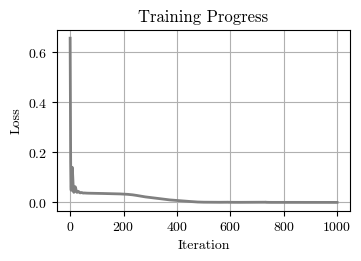

In [22]:
# Create a figure for the plot
fig = plt.figure(figsize=(3.5, 2.5))

# Plot the loss values recorded during training
plt.plot(loss_values, color='gray', linewidth=2)

# Set the labels for the x and y axes
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Set the title for the plot
plt.title('Training Progress')

# Display the grid
plt.grid(True)

# Save the plot as a PNG file in the 'imgs' directory
fig.savefig('imgs/4_Training_Progress_PINNs_including_data_loss.png', format='png')

# Display the plot
plt.show()

In [20]:
# Save the trained model's parameters to a file
torch.save(neural_net.state_dict(), 'models/4_PINNs_including_data_loss.pth')

# Initialize a new instance of the neural network
new_neural_net = NeuralNetwork()

# Load the saved parameters into the new instance of the neural network
new_neural_net.load_state_dict(torch.load('models/4_PINNs_including_data_loss.pth'))

# Ensure the new neural network is in evaluation mode
new_neural_net.eval()

NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

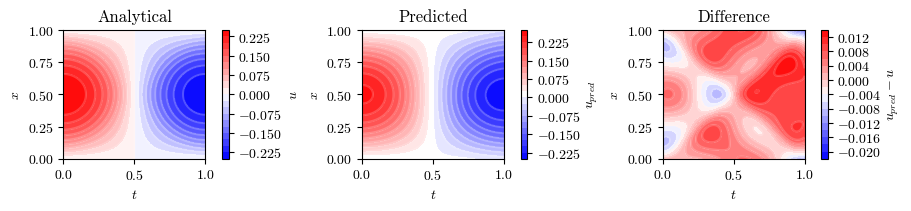

In [21]:
# Generate predictions using the neural network and reshape to match grid
u_pred = neural_net(input_data).detach().numpy().reshape(x_grid.shape)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 2))

# Define a function to plot a contour graph
def plot_contour(ax, x, y, z, title, label):
    im = ax.contourf(x, y, z, origin='lower', levels=20, cmap=utils_plots.cmap_)
    ax.set_title(title)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    fig.colorbar(im, ax=ax, label=label)
    ax.contour(x, y, z, levels=20, colors='white', alpha=0.2, linestyles='solid')

# Plot the predicted u values
plot_contour(axs[0], t_grid, x_grid, u_grid, 'Analytical', '$u$')

# Plot the predicted u values
plot_contour(axs[1], t_grid, x_grid, u_pred, 'Predicted', '$u_{pred}$')

# Plot the difference between the predicted and analytical u values
plot_contour(axs[2], t_grid, x_grid, u_pred-u_grid, 'Difference', '$u_{pred}-u$')

# Save the plot as a PDF file in the 'imgs' directory
fig.savefig('imgs/4_Predicted_and_Difference_PINNs_including_data_loss.png', format='png')

# Display the plot
plt.show()

**Summary**

In this notebook, we extended our approach from the previous notebooks by incorporating both physical loss and data loss during training. This integration allows us to evaluate the combined impact on training time and accuracy.

- Neural Network Architecture: Two hidden layers with 10 neurons each, employing the hyperbolic tangent activation function.
- Optimizer: Adam optimizer with a learning rate of 0.01.
- Training Iterations: 1000 iterations.
- Loss Functions: Mean Squared Error (MSE) for boundary and physics conditions.
- Additional MSE loss for data fitting.